In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

gamma = 50
alpha = 1e6

# defining the Lennard jones potential
def v(x):
    return 4*(1/x**12 - 1/x**6)

# internal part of the Schrodinger eqn, in the Numerov general form y"(t) = g(t)y
def g(x, ek):
    return gamma**2 * abs(v(x) - ek)

def returnCTPs(ek):
    #Calculating the CTPs, root_scalar returns object with execulation results, unpacking needed for actual root
    ctp_left = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.0, x1=1.0 + 1e-4)
    ctp_right = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.25, x1=1.25 + 1e-4)

    xa = ctp_left.root
    xb = ctp_right.root
    
    return xa,xb

def return_limits_for_E(ek):
    xa, xb = returnCTPs(ek)
    
    xs = root_scalar(
            lambda x: np.sqrt(g(x,ek)) * (xa - x) - np.log(alpha),
            bracket=[0.1,3],
            method='bisect',
        )
        # applying the same for end limit
        # func: sqrt{g(xe)} (xe-xb) ln A
    xe = root_scalar(
            lambda x: np.sqrt(g(x, ek)) * (x - xb) - np.log(alpha),
            bracket=[0.1,5],
            method='bisect',
        )
    xs = xs.root #unpacking the root_scalar object
    xe = xe.root
    return xs,xe

# Implement the refined explicit Numerov propagator
# re configured the numerov func for SE 
def numerov_for_SE(func,phi0, phi1, h, t):
    """
    Refined explicit Numerov propagator for solving y''(t) = g(t)y(t).
    
    Parameters:
    - func: The function g(t), such that y''(t) = g(t)y(t).
    - y0: Initial condition y(t0).
    - v0: Initial velocity y'(t0).
    - h: Step size for the numerical method.
    - t: Array of time points.
    
    Returns:
    - y: Array of dependent variable values computed using the explicit Numerov method.
    """
    y = np.zeros_like(t)
    
    y[0] = phi0 # two start points, as indicated by the setup
    y[1] = phi1  

    for n in range(1, len(t) - 1):
        # Compute coefficients a, b, c
        g_n = func(t[n])
        g_n_minus_1 = func(t[n - 1])
        g_n_plus_1 = func(t[n + 1])

        a = 2 + (5 / 6) * g_n * h**2
        b = 1 - (1 / 12) * g_n_minus_1 * h**2
        c = 1 - (1 / 12) * g_n_plus_1 * h**2

        # Update y[n+1] explicitly
        y[n + 1] = (a * y[n] - b * y[n - 1]) / c

    return y

def g_for_SE(x,ek):
    return gamma**2 * (v(x) - ek)
    

Since we are creating the plot for only a specific case (k=5), we now compute it as follows

In [8]:
# # defining the x-grid
# dx = 0.01 
# x = np.arange(0.99, 3, dx)
# vx = [v(i) for i in x ]

# plotting the lennard jones potential
# plt.figure(figsize=(10, 10))

# plt.plot(x, vx,color='k', label="LJ Potential", linewidth = 1)
# plt.xlabel("x")
# plt.ylabel("V(x)")

energy = []
dx_sizes = [ 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, ]

for dx in dx_sizes:
    
    # # defining the x-grid
    # dx from loop
    x = np.arange(0.99, 3, dx)
    vx = [v(i) for i in x ]
    
     
    iter = 1
    k= 5 # as the question mentions
    e_upper = 0
    e_lower = -1.0

    phi_x_e_prev = 0 # for comparison, follows below

    while iter <= 100:
        e_mid = (e_upper + e_lower)/2
        
        
        # making calculations for current value of e_mid
        xs, xe = return_limits_for_E(e_mid)
        # dx = 0.001
        x_range = np.arange(xs-dx, xe+dx, dx)
        phi = numerov_for_SE(
            lambda x: g_for_SE(x,e_mid),
            phi0 = 0,
            phi1 = 1,
            h=dx,
            t=x_range
        )
        
        # calculating the nodes in the computed phi
        nodes = 0
        for i in range(0, phi.size-1):
            if(phi[i]*phi[i+1] < 0):
                nodes = nodes + 1 
        
        
        # adjust the energy as per the node information
        if nodes > k:
            e_upper = e_mid
        else:
            e_lower = e_mid
        
        # termination if convergence is reached. Tolerance low here as the wavefn has not been normalised. After normalisation, phi[xe] will be orders of magnitude smaller
        if k == nodes and abs(phi[-1])<1e-6:     
            break
        
        # if tolerance is not hit, but the code hits numerical limit and starts to repeat the calculations
        if nodes == k and abs(phi_x_e_prev - phi[-1]) < 1e-12:
            break
        
        phi_x_e_prev = phi[-1] # to save the calculation of this iteration for comparison in the next 
        iter = iter + 1

    # normalisation of the wavefunction
    phi = phi / np.sqrt(np.dot(phi,phi))
    ek = e_mid # as, this is the root

    
    energy.append(ek)
    
    # print(f"Phi_xe (after Normalisation): {phi[-1]}") # should be extremely low (approx 0, analytically, for well=behaved) 
    # print("NORM OF THE FINAL WAVEFunc:",np.dot(phi, phi)) # norm = 1
    # print("---"*30)

    # # for the plots, we need to highlight these as asked in the question
    # xa, xb = returnCTPs(ek=e_mid)
    # xs, xe = return_limits_for_E(ek=e_mid) 
    # plt.scatter(xa, ek, marker="s", c='k', s=25)
    # plt.scatter(xb, ek, marker="s",c='k', s=25 )
    # plt.scatter(xs, ek, marker='o', color = 'r', s=25)
    # plt.scatter(xe, ek, marker='o', color= 'r', s=25)
    # plt.hlines(y=ek, xmin=xs, xmax=xe, color='r', linestyle='--', linewidth=0.5, label=f"e{k}={ek}, nodes/k = {nodes}/{k}")
    
    # phi_shifted = phi - abs(e_mid) # shift the wavefunc plot on to actual energy level
    # plt.plot(x_range, phi_shifted, color= 'b', linewidth = 1)

# plt.title("TISE Eigenstates for LJ Dimenrs using the Numerov method")
# plt.tight_layout()
# plt.grid()
# plt.legend()



Text(0.5, 0, 'Decreasing step sizes(or, increasing integration steps) --->')

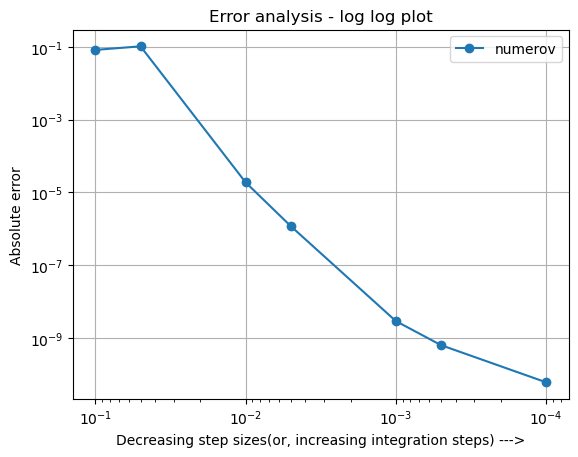

In [9]:
# now we have the list of energies corresponding to each of the step size
# in order to calculate the error, we consider the energy with the finest step size as the exact one.

e_exact = -0.2156338823466465
error = [abs(e-e_exact) for e in energy]

plt.plot(dx_sizes, error, "-o",label = "numerov")
plt.title("Error analysis - log log plot")
plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()  # gca() gets the current axis
plt.ylabel("Absolute error")
plt.legend()
plt.grid()
plt.xlabel("Decreasing step sizes(or, increasing integration steps) --->")
